# Credit Risk Analysis

### Import libraries

In [79]:
import os
import math
import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True)

### Load data

In [80]:
filepath = os.path.join('..', 'resources', 'df_criado_final.csv')
df = pd.read_csv(filepath, delimiter=',')

### Data exploration

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50390 entries, 0 to 50389
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Escolaridade                 14615 non-null  float64
 1   Renda Mensal Informal        9768 non-null   float64
 2   Dependentes                  50390 non-null  object 
 3   Estado Civil                 50390 non-null  int64  
 4   Idade                        50390 non-null  int64  
 5   Conta Poupanca               50390 non-null  object 
 6   Conta Salario                50390 non-null  object 
 7   Quant Adiantamento Deposito  21843 non-null  float64
 8   Qtd Fonte Renda              12806 non-null  float64
 9   Cheque Sem Fundo             50390 non-null  object 
 10  Conta Conjunta               50390 non-null  object 
 11  Valor Conta Corrente         0 non-null      float64
 12  Valor Conta Poupanca         0 non-null      float64
 13  Valor Emprestimo

### Basic metrics of features and target

In [82]:
df.describe()

,Escolaridade,Renda Mensal Informal,Estado Civil,Idade,Quant Adiantamento Deposito,Qtd Fonte Renda,Valor Conta Corrente,Valor Conta Poupanca,Valor Emprestimo,Multa,Juros,Valor Emprestimo Atualizado,PAGO,Controle,ID,Genero,Estado
count,14615.000000,9768.000000,50390.000000,50390.000000,21843.000000,12806.000000,0.0,0.0,5.039000e+04,5.039000e+04,5.039000e+04,5.039000e+04,50390.000000,50390.0,5.039000e+04,50390.000000,50390.000000
mean,1.175573,4635.610641,3.503354,31.724529,2.104931,1.241605,NaN,NaN,5.198927e+04,6.022658e+04,6.485391e+04,1.721779e+05,0.790891,1.0,3.740829e+09,0.498333,57.498055
std,0.508951,24776.361024,2.132091,8.565117,0.898459,0.496176,NaN,NaN,1.588819e+06,2.843941e+06,2.728170e+06,7.058290e+06,0.406676,0.0,7.248462e+09,0.500002,1.118008
min,1.000000,0.009600,1.000000,18.000000,1.000000,1.000000,NaN,NaN,1.431000e+03,0.000000e+00,0.000000e+00,1.441500e+03,0.000000,1.0,1.168846e+06,0.000000,56.000000
25%,1.000000,28.173400,2.000000,26.000000,2.000000,1.000000,NaN,NaN,1.593000e+03,1.325675e+02,2.742725e+02,2.840910e+03,1.000000,1.0,1.383124e+06,0.000000,56.000000
50%,1.000000,186.004900,2.000000,30.000000,2.000000,1.000000,NaN,NaN,2.298035e+03,6.489650e+02,1.143320e+03,5.609805e+03,1.000000,1.0,1.439557e+06,0.000000,57.000000
75%,1.000000,1159.021800,4.000000,35.000000,2.000000,1.000000,NaN,NaN,7.172175e+03,3.600000e+03,5.545427e+03,1.791325e+04,1.000000,1.0,4.699642e+07,1.000000,58.000000
max,3.000000,516960.779100,11.000000,113.000000,18.000000,3.000000,NaN,NaN,2.867894e+08,5.737759e+08,5.703619e+08,1.430927e+09,1.000000,1.0,2.399887e+10,1.000000,59.000000


In [83]:
df.head()

,Escolaridade,Renda Mensal Informal,Dependentes,Estado Civil,Idade,Conta Poupanca,Conta Salario,Quant Adiantamento Deposito,Qtd Fonte Renda,Cheque Sem Fundo,...,Valor Emprestimo,Multa,Juros,Valor Emprestimo Atualizado,PAGO,Controle,ID,Genero,Data,Estado
0,NaN,NaN,S,2,36,S,N,NaN,NaN,N,...,8174.32,263.25,5844.98,14282.55,1,1,1328587.0,1,2020-01-01,57
1,1.0,1894.5078,N,2,39,S,N,2.0,1.0,S,...,41775.63,1607.29,7652.26,51035.18,1,1,1424254.0,1,2020-01-01,59
2,1.0,NaN,S,2,26,S,N,NaN,1.0,S,...,522940.27,24860.40,319315.62,867116.29,1,1,1438519.0,0,2020-01-01,56
3,NaN,NaN,N,8,23,N,N,NaN,NaN,N,...,1593.00,21472.36,2967.48,26032.84,1,1,1426138.0,1,2020-01-01,56
4,NaN,NaN,S,2,33,S,N,NaN,NaN,N,...,2078.97,19.44,46.35,2144.76,1,1,1474504.0,0,2020-01-01,59


### Amount of different values for each feature

Note: not using df.nunique(), since NaN is not counted as an unique value.

In [84]:
{ col: df[col].unique().size for col in df.columns }

{'Escolaridade': 4,
 'Renda Mensal Informal': 2342,
 'Dependentes': 2,
 'Estado Civil': 9,
 'Idade': 77,
 'Conta Poupanca': 2,
 'Conta Salario': 2,
 'Quant Adiantamento Deposito': 16,
 'Qtd Fonte Renda': 4,
 'Cheque Sem Fundo': 2,
 'Conta Conjunta': 2,
 'Valor Conta Corrente': 1,
 'Valor Conta Poupanca': 1,
 'Valor Emprestimo': 28577,
 'Multa': 33777,
 'Juros': 42139,
 'Valor Emprestimo Atualizado': 43191,
 'PAGO': 2,
 'Controle': 1,
 'ID': 45784,
 'Genero': 2,
 'Data': 1,
 'Estado': 4}

### Proportion of target values

1    0.790891
0    0.209109
Name: PAGO, dtype: float64

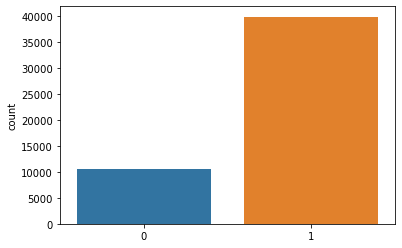

In [85]:
sns.countplot(df[target].values)
df[target].value_counts() / df.shape[0]

### Proportion of missing values of each feature

In [86]:
df.isnull().mean().sort_values(ascending=False)

Valor Conta Corrente           1.000000
Valor Conta Poupanca           1.000000
Renda Mensal Informal          0.806152
Qtd Fonte Renda                0.745862
Escolaridade                   0.709962
Quant Adiantamento Deposito    0.566521
PAGO                           0.000000
Valor Emprestimo Atualizado    0.000000
Genero                         0.000000
Dependentes                    0.000000
Estado Civil                   0.000000
Idade                          0.000000
Conta Poupanca                 0.000000
Conta Salario                  0.000000
ID                             0.000000
Cheque Sem Fundo               0.000000
Conta Conjunta                 0.000000
Data                           0.000000
Controle                       0.000000
Valor Emprestimo               0.000000
Multa                          0.000000
Juros                          0.000000
Estado                         0.000000
dtype: float64

### Basic insights

- Initially, the dataset contains 23 features, where 10 of them are categorical and 13 are numerical, and a target column called 'PAGO';

- 'ID' is the only feature that does not have relation with credit risk;

- The features 'Valor Conta Corrente', 'Valor Conta Poupanca', 'Controle' and 'Data' only contain one unique value, therefore they will not be useful for information retrieval;

- The target values are unbalanced; approximately 79% of the dataset contains the entries where the target value is 1, while the rest contains the entries where the target value is 0. Therefore, accuracy does not seem as a good metric to evaluate a classification model for this task on this dataset;

- At 'Valor Conta Corrente' and 'Valor Conta Poupanca' features, seems that all values are missing, while 'Renda Mensal Informal', 'Qtd Fonte Renda', 'Escolaridade' and 'Quant Adiantamento Deposito' have a considerable amount of missing values. Is the data missing at random or are there patterns?
    - Possible types of missing data:
        - Missing completely at random (MCAR);
        - Missing at random (MAR);
        - Missing not at random (MNAR).
    - Possible solutions:
        - Listwise / Case deletion (if MCAR);
        - Pairwise deletion (if MCAR or MAR);
        - Mean substitution (not generally accepted);
        - Regression imputation (no novel information is added);
        - Last observation carried forward;
        - Maximum likelihood (good for large samples);
        - Expectation-Maximization;
        - Multiple imputation (good for large samples);
        - Sensitivity analysis.
    - Source: Kang, Hyun. "The prevention and handling of the missing data." Korean journal of anesthesiology 64.5 (2013): 402.

### Target name

In [87]:
target = 'PAGO'

### Drop features not related to credit risk

In [88]:
not_related_features = ['ID']
df = df.drop(columns=not_related_features, errors='ignore')

### Drop features with unique values

In [89]:
unique_value_features = [col for col in df.columns if df[col].unique().size == 1]
df = df.drop(columns=unique_value_features, errors='ignore')

### Drop features with a proportion of missing values

For now, using a threshold value of 80%.

In [90]:
missing_threshold = 0.8

high_prop_missing_features = [col for col in df.columns if df[col].isnull().mean() >= missing_threshold]
df = df.drop(columns=high_prop_missing_features, errors='ignore')

### Dataset structure after removals:

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50390 entries, 0 to 50389
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Escolaridade                 14615 non-null  float64
 1   Dependentes                  50390 non-null  object 
 2   Estado Civil                 50390 non-null  int64  
 3   Idade                        50390 non-null  int64  
 4   Conta Poupanca               50390 non-null  object 
 5   Conta Salario                50390 non-null  object 
 6   Quant Adiantamento Deposito  21843 non-null  float64
 7   Qtd Fonte Renda              12806 non-null  float64
 8   Cheque Sem Fundo             50390 non-null  object 
 9   Conta Conjunta               50390 non-null  object 
 10  Valor Emprestimo             50390 non-null  float64
 11  Multa                        50390 non-null  float64
 12  Juros                        50390 non-null  float64
 13  Valor Emprestimo

In [92]:
cat = ['Escolaridade', 'Dependentes', 'Estado Civil', 'Conta Poupanca', 'Conta Salario',
    'Cheque Sem Fundo', 'Conta Conjunta', 'Genero', 'Estado']
num = ['Idade', 'Quant Adiantamento Deposito', 'Qtd Fonte Renda', 'Valor Emprestimo', 'Multa', 'Juros',
    'Valor Emprestimo Atualizado']

### Analyze numerical features

Firstly, boxplot are used to verify how each numerical feature concentrates, grouping by the target value.

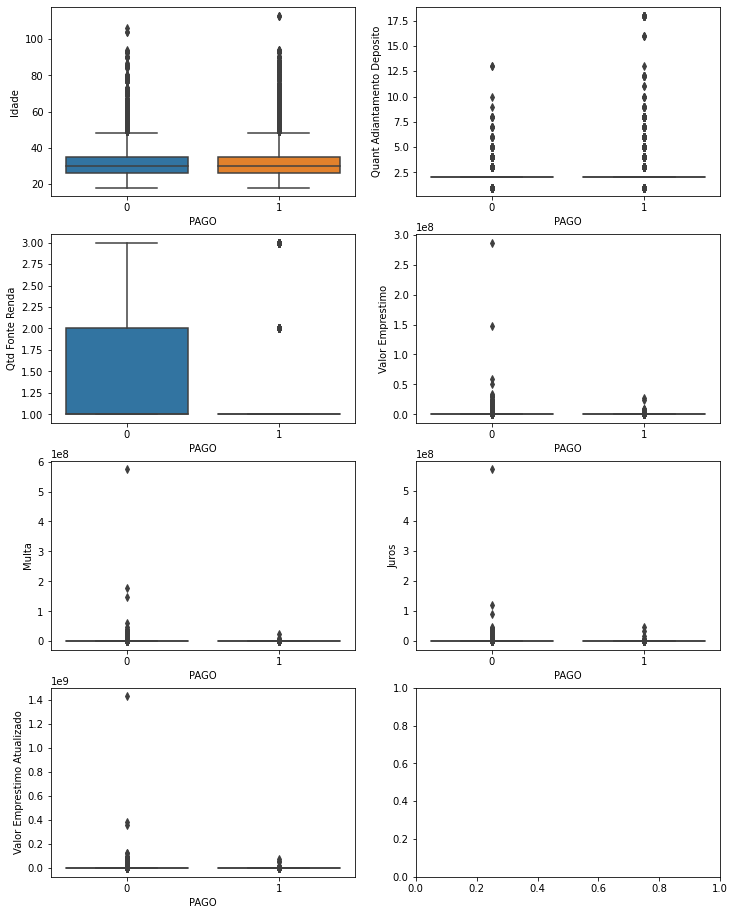

In [96]:
ncols = 2
nrows = 4
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12,16))

for i, col in enumerate(num):
    c = i % ncols
    r = i // ncols
    
    sns.boxplot(x=target, y=col, data=df, ax=ax[r][c])

Only the 'Idade' feature we could obtain a glimpse of how data concentrates.

So, using distplot to analyze the distribution of each feature, grouped by the target value.

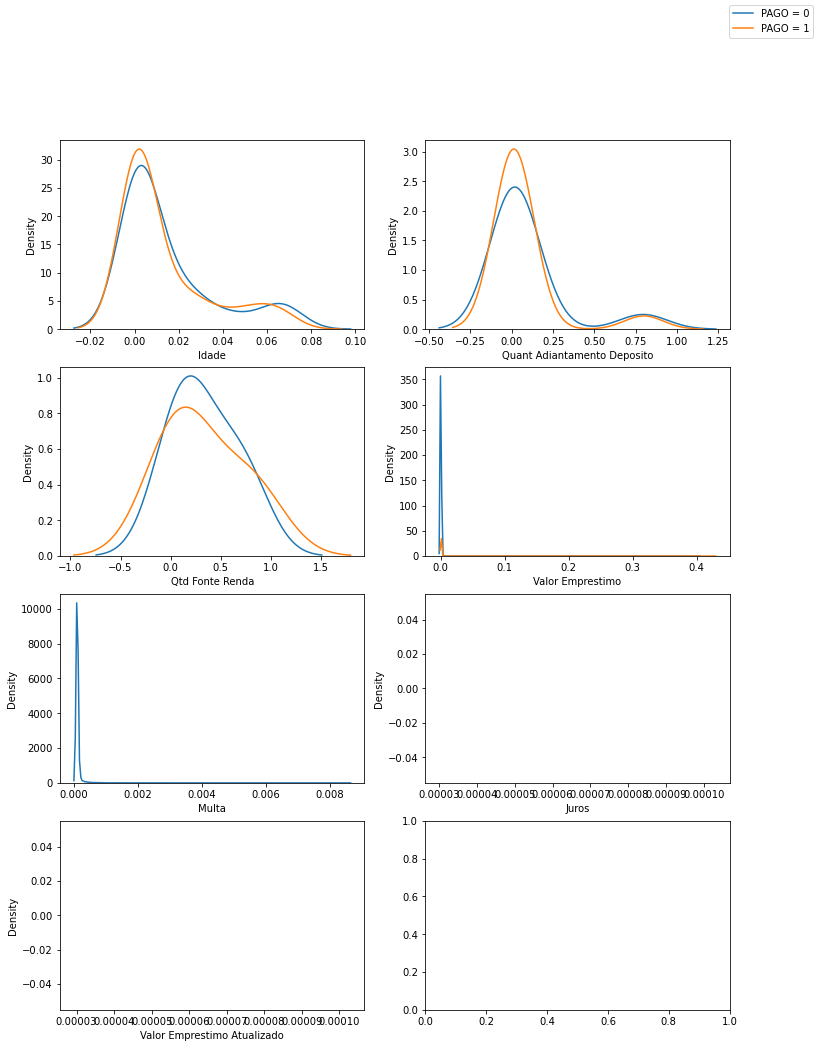

In [97]:
ncols = 2
nrows = 4
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12,16))

for i, col in enumerate(num):
    c = i % ncols
    r = i // ncols

    sns.distplot(df[df[target] == 0][col].value_counts(normalize=True), hist=False, ax=ax[r][c])
    sns.distplot(df[df[target] == 1][col].value_counts(normalize=True), hist=False, ax=ax[r][c])
    
fig.legend(labels=['%s = 0' % target, '%s = 1' % target])

In this case, we could have a visualization of how the 'Quant Adiantamento Deposito' and 'Qtd Fonte Renda' is distributed.

So, going for boxplot again, but in this case I desconsider outlier entries (and still grouping by the target value).

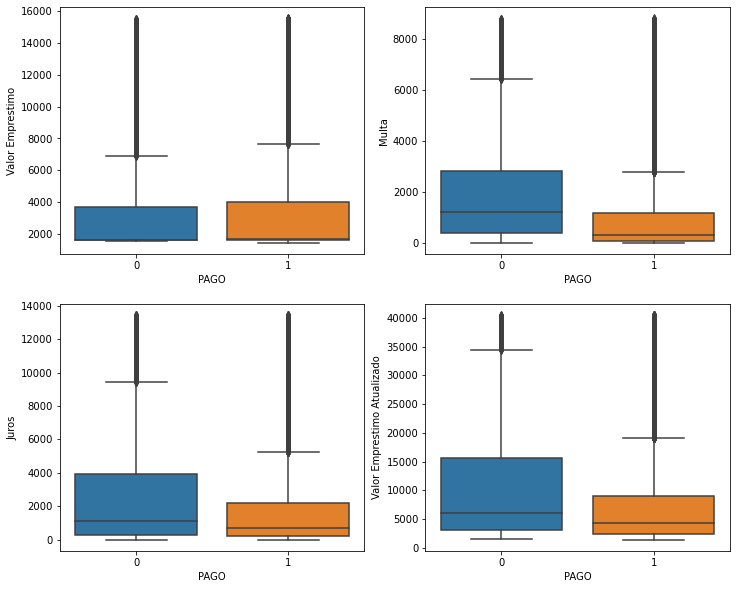

In [98]:
ncols = 2
nrows = 2
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12,10))

for i, col in enumerate(['Valor Emprestimo', 'Multa', 'Juros', 'Valor Emprestimo Atualizado']):
    c = i % ncols
    r = i // ncols
    
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    min_not_outlier = q1 - 1.5 * iqr
    max_not_outlier = q3 + 1.5 * iqr
    
    df_interval_by_col = df[df[col].between(min_not_outlier, max_not_outlier)]
    
    sns.boxplot(x=target, y=col, data=df_interval_by_col, ax=ax[r][c])

### Insights from numerical features

- 'Idade', 'Quant Adiantamento Deposito' and 'Qtd Fonte Renda' features do not show considerable difference when divided by target values;
- Slightly higher values of 'Valor Emprestimo' (desconsidering outliers) tend to target values of 1;
- Higher values of 'Multa', 'Juros' and 'Valor Emprestimo Atualizado' (desconsidering outliers) tend to target values of 0.

### Analyze categorical features

For that, countplot is used, where the amount of occurences of each categorical feature is divided by the target value and the possible values the categorical feature may assume.

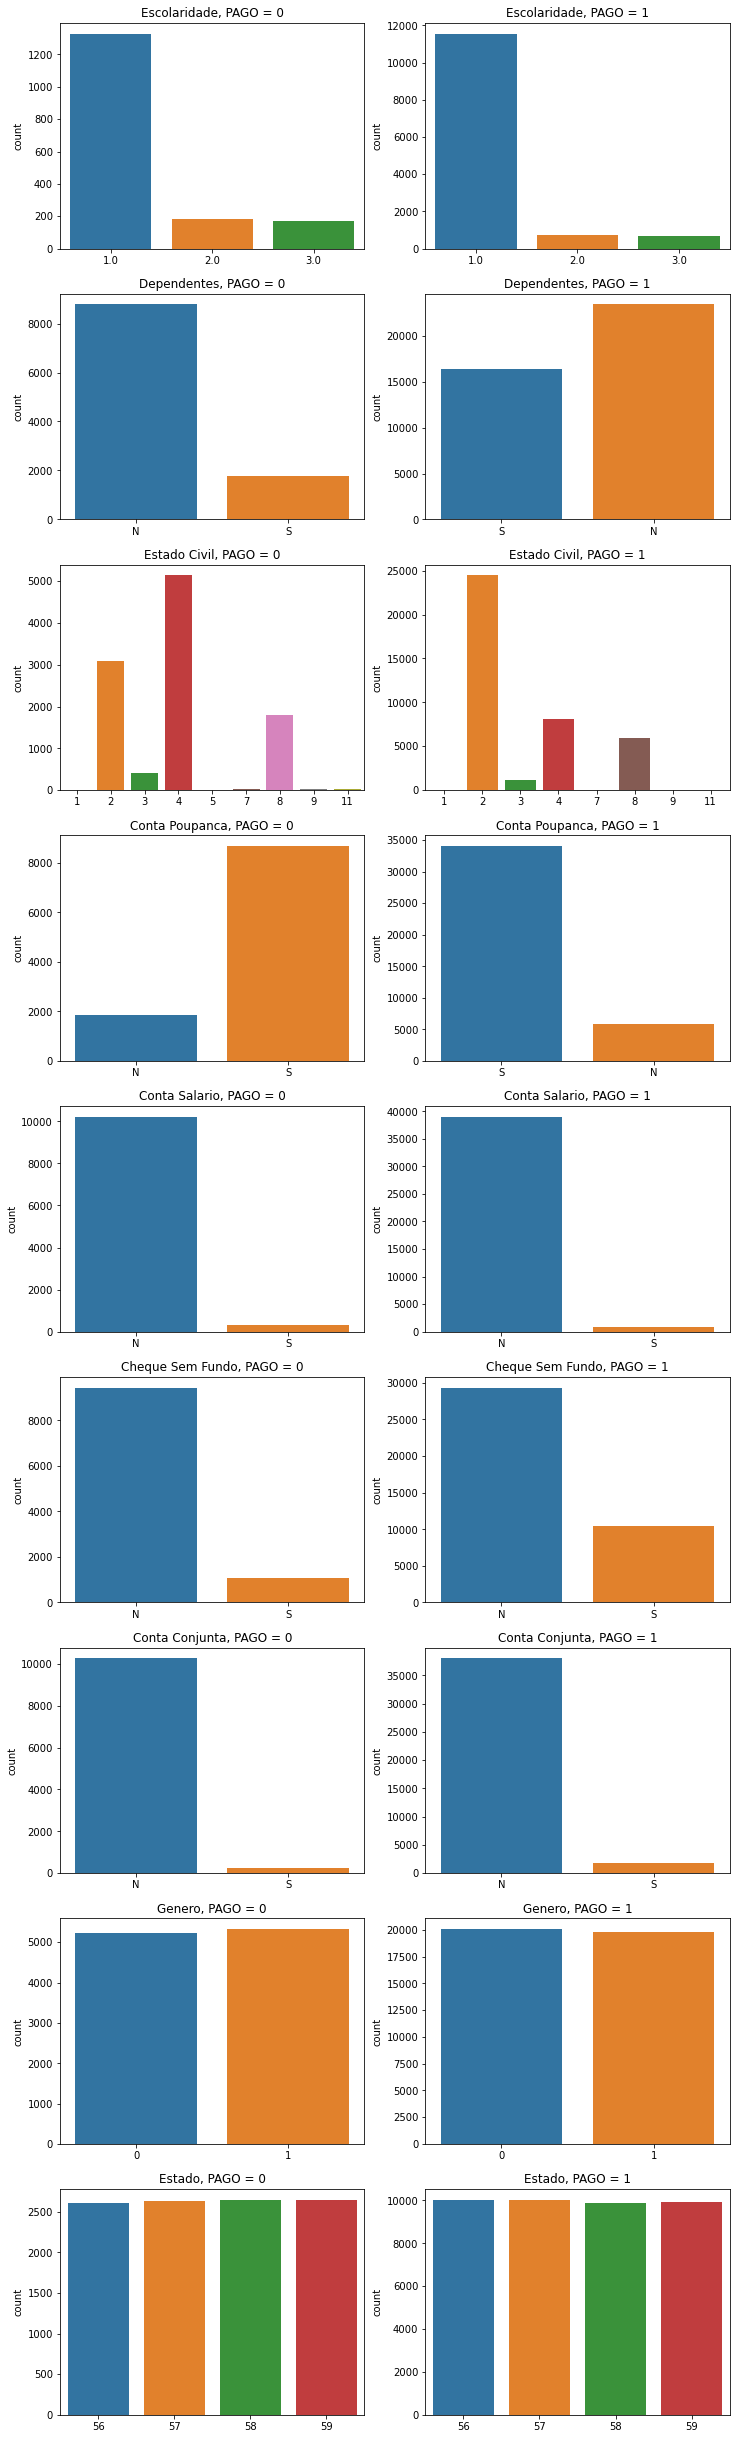

In [100]:
ncols = 2
nrows = 9
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12, 44))

for i, col in enumerate(cat):
    c = (i * 2) % ncols
    r = (i * 2) // ncols
    
    for p in [0, 1]:
        ax[r][c+p].title.set_text('%s, %s = %s' % (col, target, p))
        sns.countplot(df[df[target] == p][col].values, x=col, ax=ax[r][c+p])

### Insights from categorical features

- 'Escolaridade' values of '1' slightly tend to target values of 1;
- 'Dependentes' values of 'S' tend to target values of 1;
- 'Estado Civil' values of '2' tend to target values of 1;
- 'Estado Civil' values of '4' tend to target values of 0;
- 'Cheque Sem Fundo' values of '1' tend to target values of 1;
- 'Conta Poupanca', 'Conta Salario', 'Conta Conjunta', 'Genero' and 'Estado' features do not show considerable difference when divided by target values.

### Analyze correlation between features

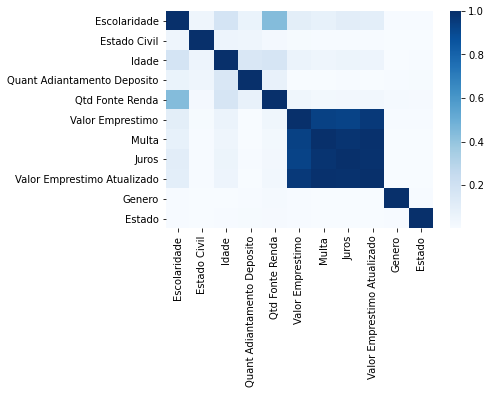

In [101]:
corr_matrix = df.drop(target, axis=1).corr().abs()
sns.heatmap(corr_matrix, cmap='Blues')

Features that have a correlation of more than 95% with other features are removed.

In [102]:
corr_upper_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
high_corr_cols = [col for col in corr_upper_matrix.columns if any(corr_upper_matrix[col] > 0.95)]

print(high_corr_cols)
df = df.drop(columns=high_corr_cols, errors='ignore')

['Juros', 'Valor Emprestimo Atualizado']


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50390 entries, 0 to 50389
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Escolaridade                 14615 non-null  float64
 1   Dependentes                  50390 non-null  object 
 2   Estado Civil                 50390 non-null  int64  
 3   Idade                        50390 non-null  int64  
 4   Conta Poupanca               50390 non-null  object 
 5   Conta Salario                50390 non-null  object 
 6   Quant Adiantamento Deposito  21843 non-null  float64
 7   Qtd Fonte Renda              12806 non-null  float64
 8   Cheque Sem Fundo             50390 non-null  object 
 9   Conta Conjunta               50390 non-null  object 
 10  Valor Emprestimo             50390 non-null  float64
 11  Multa                        50390 non-null  float64
 12  PAGO                         50390 non-null  int64  
 13  Genero          

### Missing values

At this point, only 'Escolaridade', 'Quant Adiantamento Deposito' and 'Qtd Fonte Renda' features contain missing values.

Using boxplot, we compare the proportion of the target occurences on the dataset with those where one of each of the three aforementioned feature values are all null.

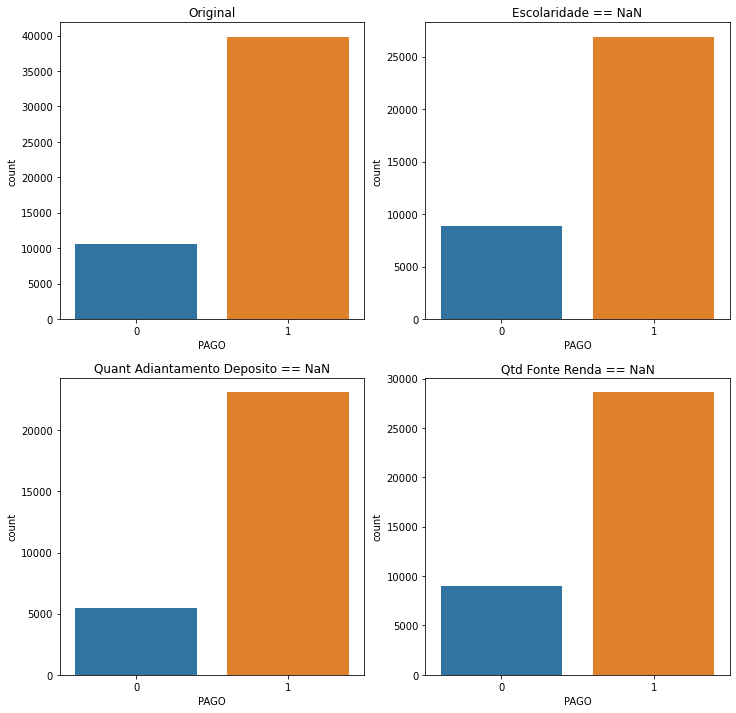

In [104]:
ncols = 2
nrows = 2
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12, 12))

ax[0][0].title.set_text('Original')
sns.countplot(df[target], ax=ax[0][0])

for i, col in enumerate(['Escolaridade', 'Quant Adiantamento Deposito', 'Qtd Fonte Renda']):
    c = (i + 1) % ncols
    r = (i + 1) // ncols
    
    ax[r][c].title.set_text('%s == NaN' % col)
    sns.countplot(df[df[col].isnull()][target], x=col, ax=ax[r][c])

Although more analysis are needed, looks like those three features are randomly missing features.

- For the categorical feature 'Escolaridade', filling NaN's with zeros is an approach, as it would be interpret as a category of 'Escolaridade';
- For 'Quant Adiantamento Deposito' and 'Qtd Fonte Renda',

In [76]:
df = df.fillna(0)

In [42]:
cat = ['Escolaridade', 'Dependentes', 'Estado Civil', 'Conta Poupanca', 'Conta Salario', 'Qtd Fonte Renda',
    'Cheque Sem Fundo', 'Conta Conjunta', 'Genero', 'Estado']
num = ['Idade', 'Quant Adiantamento Deposito', 'Valor Emprestimo', 'Multa']

### Split dataset

In [43]:
X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Categorical feature selection

In [44]:
X_train_cat = X_train[cat].copy()

chi2 = { 'features': [], 'p_values': [] }
for col in cat:
    _, p_value, _, _ = scipy.stats.chi2_contingency(pd.crosstab(y_train, X_train_cat[col]))
    chi2['features'].append(col)
    chi2['p_values'].append(p_value)
    
df_chi2 = pd.DataFrame(data=chi2).sort_values(by='p_values', ascending=True)
df_chi2

,features,p_values
1,Dependentes,0.000000e+00
2,Estado Civil,0.000000e+00
6,Cheque Sem Fundo,1.855636e-212
0,Escolaridade,4.354686e-206
5,Qtd Fonte Renda,8.393099e-145
7,Conta Conjunta,8.754044e-18
3,Conta Poupanca,5.484030e-14
4,Conta Salario,3.181974e-06
8,Genero,1.033840e-01
9,Estado,6.796148e-01


### Numerical feature selection

In [45]:
X_train_num = X_train[num].copy()

F_statistic, p_values = f_classif(X_train_num, y_train)
ANOVA_F = { 'features': X_train_num.columns.values, 'F_score': F_statistic, 'p_values': p_values }

df_ANOVA_F = pd.DataFrame(data=ANOVA_F).sort_values(by='F_score', ascending=False)
df_ANOVA_F

,features,F_score,p_values
3,Multa,155.897606,1.037940e-35
2,Valor Emprestimo,152.345137,6.159799e-35
1,Quant Adiantamento Deposito,31.781137,1.737119e-08
0,Idade,19.430252,1.046104e-05


In [46]:
cat_best = df_chi2[df_chi2['p_values'] < 0.05]['features'].values.tolist()
num_best = df_ANOVA_F[df_ANOVA_F['p_values'] < 0.05]['features'].values.tolist()

X_train = X_train[cat_best + num_best]
X_test = X_test[cat_best + num_best]

X_train.head()

,Dependentes,Estado Civil,Cheque Sem Fundo,Escolaridade,Qtd Fonte Renda,Conta Conjunta,Conta Poupanca,Conta Salario,Multa,Valor Emprestimo,Quant Adiantamento Deposito,Idade
36935,N,2,S,1.0,1.0,N,S,N,1629.75,4852.49,2.0,28
393,S,2,N,1.0,0.0,N,S,N,97.26,4024.45,0.0,30
47806,N,4,N,0.0,0.0,N,S,N,9600.99,20794.94,2.0,26
32448,N,2,N,0.0,0.0,N,S,N,297.58,9032.51,2.0,30
995,N,4,N,0.0,0.0,N,S,N,12.00,1893.00,0.0,46


### One-hot encoding categorical features

In [47]:
for col in cat_best:
    one_hot_col = pd.get_dummies(df[col], prefix=col)
    
    X_train = X_train.drop(col, axis=1).join(one_hot_col)
    X_test = X_test.drop(col, axis=1).join(one_hot_col)
    
X_train.head()

,Multa,Valor Emprestimo,Quant Adiantamento Deposito,Idade,Dependentes_N,Dependentes_S,Estado Civil_1,Estado Civil_2,Estado Civil_3,Estado Civil_4,...,Qtd Fonte Renda_0.0,Qtd Fonte Renda_1.0,Qtd Fonte Renda_2.0,Qtd Fonte Renda_3.0,Conta Conjunta_N,Conta Conjunta_S,Conta Poupanca_N,Conta Poupanca_S,Conta Salario_N,Conta Salario_S
36935,1629.75,4852.49,2.0,28,1,0,0,1,0,0,...,0,1,0,0,1,0,0,1,1,0
393,97.26,4024.45,0.0,30,0,1,0,1,0,0,...,1,0,0,0,1,0,0,1,1,0
47806,9600.99,20794.94,2.0,26,1,0,0,0,0,1,...,1,0,0,0,1,0,0,1,1,0
32448,297.58,9032.51,2.0,30,1,0,0,1,0,0,...,1,0,0,0,1,0,0,1,1,0
995,12.00,1893.00,0.0,46,1,0,0,0,0,1,...,1,0,0,0,1,0,0,1,1,0


### Scale numerical features

In [48]:
X_train[num_best] = StandardScaler().fit_transform(X_train[num_best])
X_test[num_best] = StandardScaler().fit_transform(X_test[num_best])

X_train.head()

,Multa,Valor Emprestimo,Quant Adiantamento Deposito,Idade,Dependentes_N,Dependentes_S,Estado Civil_1,Estado Civil_2,Estado Civil_3,Estado Civil_4,...,Qtd Fonte Renda_0.0,Qtd Fonte Renda_1.0,Qtd Fonte Renda_2.0,Qtd Fonte Renda_3.0,Conta Conjunta_N,Conta Conjunta_S,Conta Poupanca_N,Conta Poupanca_S,Conta Salario_N,Conta Salario_S
36935,-0.035598,-0.042226,0.918089,-0.434888,1,0,0,1,0,0,...,0,1,0,0,1,0,0,1,1,0
393,-0.036783,-0.043077,-0.764413,-0.200002,0,1,0,1,0,0,...,1,0,0,0,1,0,0,1,1,0
47806,-0.029433,-0.025839,0.918089,-0.669774,1,0,0,0,0,1,...,1,0,0,0,1,0,0,1,1,0
32448,-0.036628,-0.037929,0.918089,-0.200002,1,0,0,1,0,0,...,1,0,0,0,1,0,0,1,1,0
995,-0.036849,-0.045268,-0.764413,1.679088,1,0,0,0,0,1,...,1,0,0,0,1,0,0,1,1,0


### Training

In [49]:
models_search = {
    'random_forest': RandomizedSearchCV(
        estimator=RandomForestClassifier(),
        param_distributions={
            'bootstrap': [True, False],
            'max_depth': [3, 5, 10, 20, 50],
            'n_estimators': [50, 100, 200, 500],
            'max_features': ['auto', 'sqrt'],
            'class_weight': ['balanced', None] },
        n_iter=10, cv=5, verbose=5, n_jobs=-1, random_state=42),
    
    'decision_tree': RandomizedSearchCV(
        estimator=DecisionTreeClassifier(),
        param_distributions={
            'criterion': ['entropy', 'gini'],
            'max_depth': [3, 5, 10, 20],
            'max_features': np.arange(1, X_train.shape[1]),
            'class_weight': ['balanced', None] },
        n_iter=10, cv=5, verbose=5, n_jobs=-1, random_state=42),
    
    'logistic_regression': RandomizedSearchCV(
        estimator=LogisticRegression(),
        param_distributions={
            'C': np.linspace(0.1, 10, 20),
            'penalty': ['l1', 'l2'],
            'class_weight': ['balanced', None],
            'solver': ['liblinear'] },
        n_iter=10, cv=5, verbose=5, n_jobs=-1, random_state=42),

    'gaussian_nb': RandomizedSearchCV(
        estimator=GaussianNB(),
        param_distributions={},
        n_iter=10, cv=5, verbose=5, n_jobs=-1, random_state=42),

    'adaboost': RandomizedSearchCV(
        estimator=AdaBoostClassifier(),
        param_distributions={
            'n_estimators': [50, 100, 150, 200] },
        n_iter=10, cv=5, verbose=5, n_jobs=-1, random_state=42),

    'xgboost': RandomizedSearchCV(
        estimator=XGBClassifier(),
        param_distributions={
            'max_depth': [6, 10, 15, 20],
            'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
            'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
            'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
            'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
            'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
            'gamma': [0, 0.25, 0.5, 1.0],
            'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
            'n_estimators': [100] },
        n_iter=10, cv=5, verbose=5, n_jobs=-1, random_state=42) }

In [50]:
def train_search(name, model_search):
    print('training %s' % name)
    
    model_search.fit(X_train, y_train)
    model = model_search.best_estimator_
    
    return model

models = { name: train_search(name, model_search) for (name, model_search) in models_search.items() }

training random_forest
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.3min finished


training decision_tree
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished


training logistic_regression
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.4min finished


training gaussian_nb
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


training adaboost
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:   42.9s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   47.4s finished


training xgboost
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.7min finished


[14:07:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [51]:
ensemble = RandomizedSearchCV(
    estimator=VotingClassifier(estimators=list(models.items())),
    param_distributions={ 'voting': ['hard', 'soft'] },
    n_iter=10, cv=5, verbose=5, n_jobs=-1)

models['ensemble'] = train_search('ensemble', ensemble)

training ensemble
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  2.0min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.5min finished


[14:11:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [52]:
def evaluate(model):
    pred = model.predict(X_test)
    pred_mean = pred.mean()
    
    cm = confusion_matrix(y_test, pred)
    
    acc = accuracy_score(y_test, pred)
    auc = roc_auc_score(y_test, pred)
    
    tp, fp, fn, tn = cm.flatten()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = (2 * precision * recall) / (precision + recall)
    
    return { 'pred': pred, 'pred_mean': pred_mean, 'confusion_matrix': cm, 'accuracy': acc, 'auc': auc,
        'precision': precision, 'recall': recall, 'f_score': f_score }

results = { name: evaluate(model) for (name, model) in models.items() }

In [53]:
df_results = pd.DataFrame(results).transpose()
df_results.drop(columns=['pred', 'confusion_matrix']).astype(float).round(decimals=4)

,pred_mean,accuracy,auc,precision,recall,f_score
random_forest,0.5115,0.6303,0.6868,0.7841,0.3356,0.4700
decision_tree,0.3656,0.5043,0.6246,0.8315,0.2740,0.4122
logistic_regression,0.9773,0.8085,0.5465,0.0963,0.8865,0.1738
gaussian_nb,0.9862,0.7912,0.5126,0.0337,0.5108,0.0632
adaboost,0.5566,0.6533,0.6820,0.7314,0.3448,0.4687
xgboost,0.3218,0.4761,0.6206,0.8690,0.2679,0.4095
ensemble,0.5037,0.6230,0.6828,0.7855,0.3309,0.4656


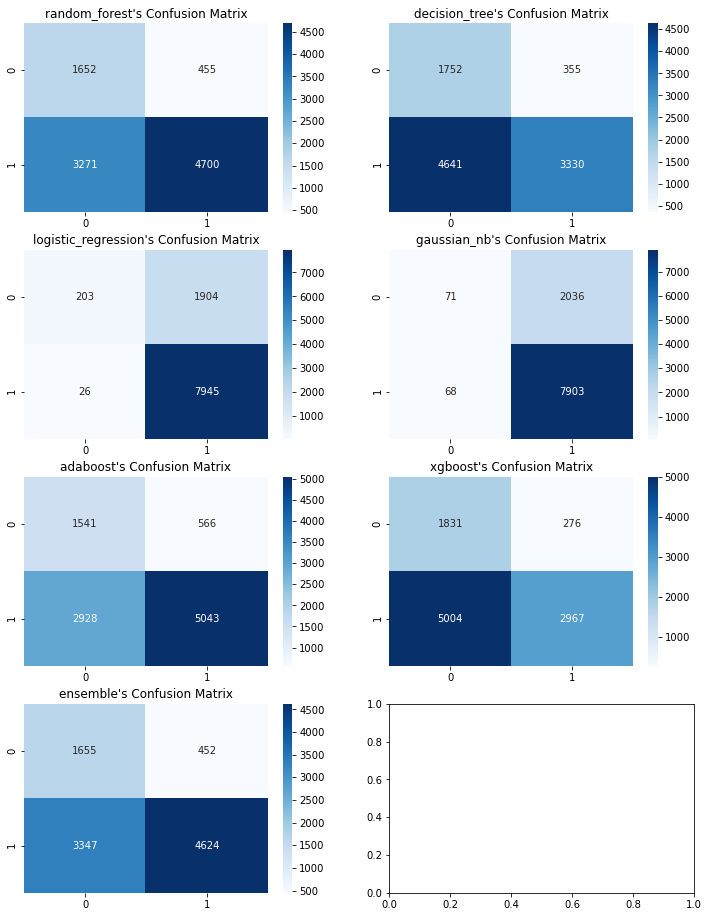

In [54]:
ncols = 2
nrows = 4
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12, 16))

for i, (name, result) in enumerate(results.items()):
    c = i % ncols
    r = i // ncols
    cm = result['confusion_matrix']
    
    ax[r][c].title.set_text('%s\'s Confusion Matrix' % name)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=ax[r][c])